In [ ]:
from keras.applications import MobileNetV2  # Updated import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Set up the dataset directories
dataset_dir = '/content/drive/MyDrive/research work/dataset/train'
img_width, img_height = 224, 224
batch_size = 32
num_classes = 4

# Step 2: Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.02,
    zoom_range=0.02,
    horizontal_flip=True,
    validation_split=0.02
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Step 3: Load MobileNetV2 and add custom layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

# Step 5: Evaluate and generate classification report
model.load_weights('best_model.keras')

test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Found 924 images belonging to 4 classes.
Found 16 images belonging to 4 classes.
Found 940 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.4767 - loss: 1.6239 
Epoch 1: val_loss improved from inf to 1.26979, saving model to best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 551s 19s/step - accuracy: 0.4793 - loss: 1.6112 - val_accuracy: 0.1875 - val_loss: 1.2698
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.7185 - loss: 0.6629
Epoch 2: val_loss improved from 1.26979 to 0.91493, saving model to best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 974ms/step - accuracy: 0.7186 - loss: 0.6619 - val_accuracy: 0.5000 - val_loss: 0.9149
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.7918 - loss: 0.4841
Epoch 3: val_loss did not improve from 0.91493
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 955ms/step - accuracy: 0.7919 - loss: 0.4844 - val_accuracy: 0.3750 - val_loss: 1.1898
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.8496 - loss: 0.3613
Epoch 4: val_loss did not improve from 0.91493
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 950ms/step - 

940/940 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step


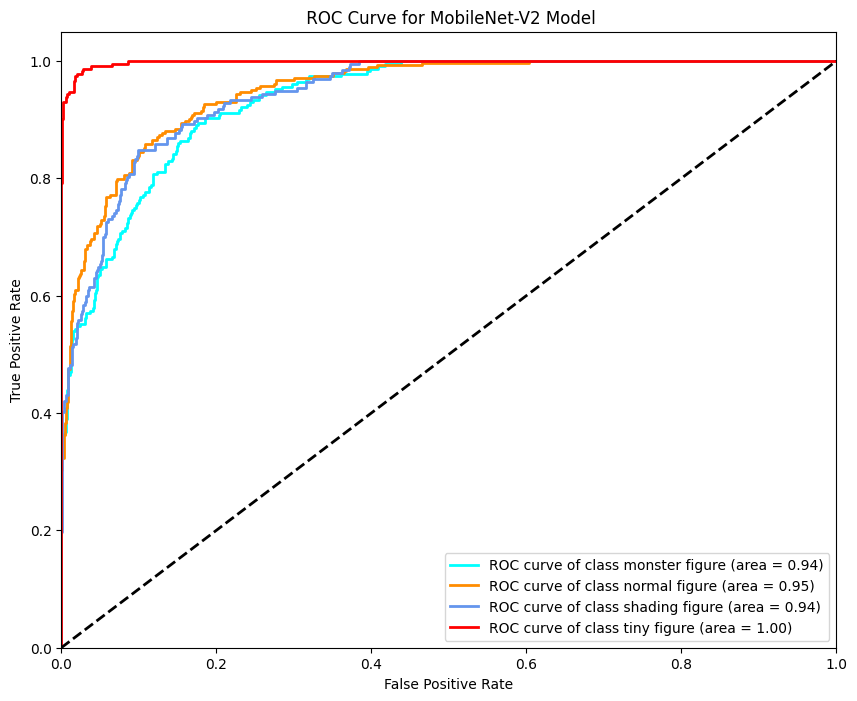


AUC Scores per Class:
Class monster figure: 0.94
Class normal figure: 0.95
Class shading figure: 0.94
Class tiny figure: 1.00


In [ ]:
# prompt: plz generate code for ROC AUC Scores and also visualize it

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 6: Calculate and visualize ROC curves and AUC scores

# Predict probabilities for ROC curve
test_generator.reset()
y_pred_proba = model.predict(test_generator, steps=test_generator.samples, verbose=1)

# Get true labels (one-hot encoded)
y_true = test_generator.classes
y_true_onehot = np.eye(num_classes)[y_true]

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC Curve for MobileNet-V2 Model')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores for each class
print("\nAUC Scores per Class:")
for i in range(num_classes):
    print(f"Class {class_labels[i]}: {roc_auc[i]:0.2f}")


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Reset test generator
test_generator.reset()

# Predict on the test set
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)




940/940 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step
                precision    recall  f1-score   support

monster figure       0.80      0.92      0.86       228
 normal figure       0.92      0.83      0.88       284
shading figure       0.89      0.88      0.88       197
   tiny figure       0.99      0.97      0.98       231

      accuracy                           0.90       940
     macro avg       0.90      0.90      0.90       940
  weighted avg       0.90      0.90      0.90       940



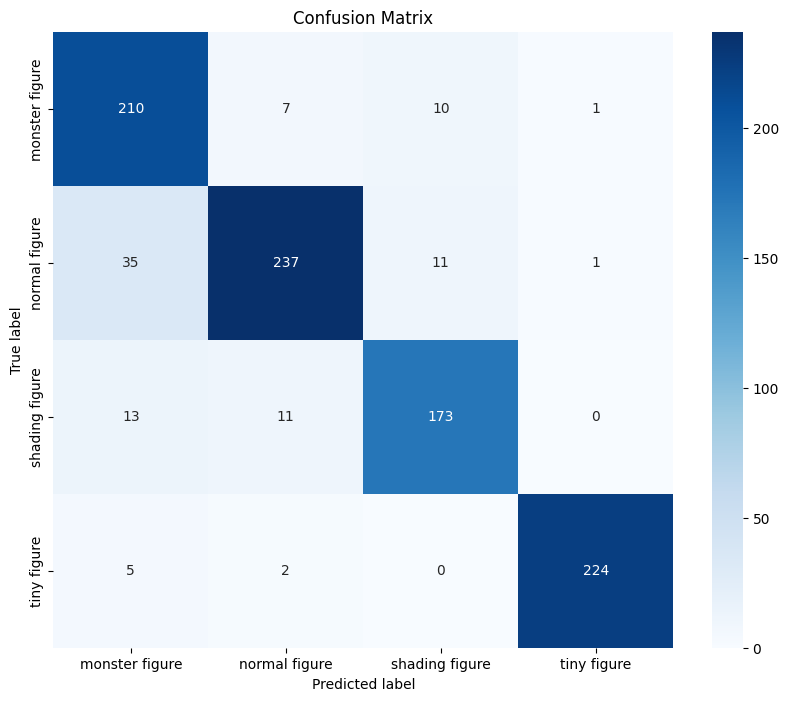

In [ ]:
# prompt: plz show the confussion metrics of this model

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# prompt: save the model

# Step 6: Save the model
model.save('/content/drive/MyDrive/research work/trained_model.keras')